# UCLA STATS 101A Final Project
**Teaching Assistant:** Jialiang Geng  
**Student:** Nam Vien -- 906178035  
**Date:** Friday, June 14th, 2024

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
from sklearn.feature_extraction import FeatureHasher
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from xgboost import XGBRegressor, plot_importance
import lightgbm as lgb
import os

# Data Exploration and Cleaning

In [2]:
# Read the data into the environment
data = pd.read_csv('uber_fare_prediction.csv')

In [3]:
# Display the dimensions of the data frame
data.shape

(200000, 8)

In [4]:
# Display the names of the columns
data.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

In [5]:
# Display the first 10 rows of the data
data.head(10)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,26:21.0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,52:16.0,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,35:00.0,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,30:42.0,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,51:00.0,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
5,50:45.0,12.1,2011-01-06 09:50:45 UTC,-74.000964,40.731630,-73.972892,40.758233,1
6,35:00.0,7.5,2012-11-20 20:35:00 UTC,-73.980002,40.751662,-73.973802,40.764842,1
7,22:00.0,16.5,2012-01-04 17:22:00 UTC,-73.951300,40.774138,-73.990095,40.751048,1
8,10:00.0,9.0,2012-12-03 13:10:00 UTC,-74.006462,40.726713,-73.993078,40.731628,1
9,11:00.0,8.9,2009-09-02 01:11:00 UTC,-73.980658,40.733873,-73.991540,40.758138,2


In [6]:
# Get the summary information of the data 
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,200000.000000,200000.000000,200000.000000,199999.000000,199999.000000,200000.000000
mean,11.342877,-72.506121,39.922326,-72.518673,39.925579,1.682445
std,9.837855,11.608097,10.048947,10.724226,6.751120,1.306730
min,-44.900000,-736.550000,-3116.285383,-1251.195890,-1189.615440,0.000000
25%,6.000000,-73.992050,40.735007,-73.991295,40.734092,1.000000
50%,8.500000,-73.981743,40.752761,-73.980072,40.753225,1.000000
75%,12.500000,-73.967068,40.767127,-73.963508,40.768070,2.000000
max,500.000000,2140.601160,1703.092772,40.851027,404.616667,6.000000


In [7]:
# Check for missing values
data.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

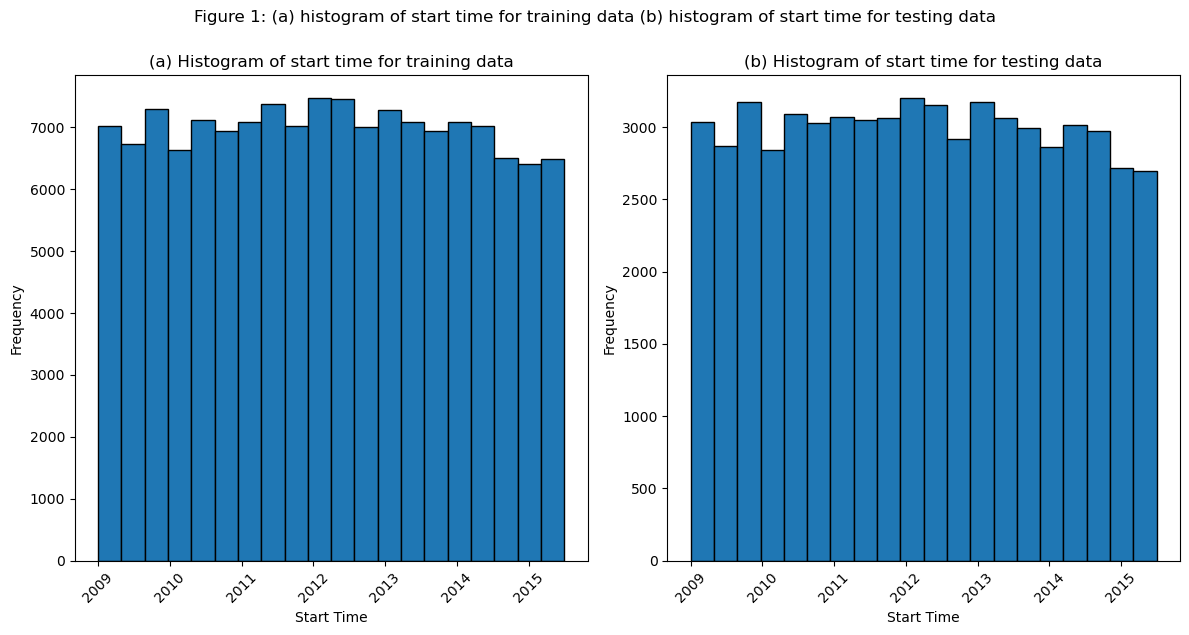

In [8]:
# Draw plots to help understand the data

# Ensure the datetime column is in datetime format
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])

# Split the data into training (70%) and testing (30%) sets
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

# Plot histogram for training data
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(train_data['pickup_datetime'], bins=20, edgecolor='black')
plt.title('(a) Histogram of start time for training data')
plt.xlabel('Start Time')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

# Plot histogram for testing data
plt.subplot(1, 2, 2)
plt.hist(test_data['pickup_datetime'], bins=20, edgecolor='black')
plt.title('(b) Histogram of start time for testing data')
plt.xlabel('Start Time')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

plt.tight_layout()
plt.suptitle('Figure 1: (a) histogram of start time for training data (b) histogram of start time for testing data', y=1.05)
plt.show()

In [9]:
# Remove extreme outliers more effectively by focusing on realistic geographic range (New York City)
data = data[(data['pickup_latitude'].between(40, 42)) & (data['pickup_longitude'].between(-74, -72))]
data = data[(data['dropoff_latitude'].between(40, 42)) & (data['dropoff_longitude'].between(-74, -72))]

In [10]:
import folium
from folium.plugins import HeatMap

# Assuming the data has already been loaded and cleaned
# Extracting a subset of the data for heatmap plotting
data_train = data.sample(40000)

# Initialize the map centered around the mean of the pickup latitude and longitude
m = folium.Map(location = [data_train.pickup_latitude.mean(), data_train.pickup_longitude.mean()], zoom_start = 9)

# Prepare the data for the heatmap
heat_data = [[row['pickup_latitude'], row['pickup_longitude']] for index, row in data_train.iterrows()]

# Add the heatmap layer to the map
HeatMap(heat_data).add_to(m)

# Save the map to an HTML file in the current working directory
output_file = 'heatmap_folium.html'
m.save(output_file)

print(f"Heatmap has been created and saved to {output_file}")

from IPython.display import IFrame

# Display the heatmap in Jupyter Notebook
IFrame(output_file, width = 600, height = 600)

Heatmap has been created and saved to heatmap_folium.html


In [11]:
# Remove extreme outliers more effectively by focusing on realistic geographic range (New York City)
data = data[(data['pickup_latitude'].between(40, 42)) & (data['pickup_longitude'].between(-74, -72))]
data = data[(data['dropoff_latitude'].between(40, 42)) & (data['dropoff_longitude'].between(-74, -72))]

In [12]:
# Display the first few rows of the cleaned data
data.head(10)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,26:21.0,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
2,35:00.0,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,30:42.0,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,51:00.0,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1
6,35:00.0,7.5,2012-11-20 20:35:00+00:00,-73.980002,40.751662,-73.973802,40.764842,1
7,22:00.0,16.5,2012-01-04 17:22:00+00:00,-73.951300,40.774138,-73.990095,40.751048,1
9,11:00.0,8.9,2009-09-02 01:11:00+00:00,-73.980658,40.733873,-73.991540,40.758138,2
10,30:50.0,5.3,2012-04-08 07:30:50+00:00,-73.996335,40.737142,-73.980721,40.733559,1
12,04:03.0,4.1,2009-11-06 01:04:03+00:00,-73.991601,40.744712,-73.983081,40.744682,2
16,22:00.0,12.5,2014-02-19 07:22:00+00:00,-73.986430,40.760465,-73.988990,40.737075,1


In [13]:
# Display summary statistics of the cleaned data
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,150976.000000,150976.000000,150976.000000,150976.000000,150976.000000,150976.000000
mean,11.026938,-73.969078,40.755652,-73.967577,40.756510,1.677942
std,9.655898,0.039796,0.030285,0.038135,0.033011,1.306510
min,-44.900000,-74.000000,40.121653,-74.000000,40.164927,0.000000
25%,5.700000,-73.987497,40.743828,-73.986107,40.743862,1.000000
50%,8.100000,-73.978262,40.758294,-73.976638,40.758524,1.000000
75%,12.000000,-73.963847,40.771019,-73.960691,40.772425,2.000000
max,500.000000,-72.856968,41.650000,-72.854940,41.543217,6.000000


In [14]:
# Check for missing values
data.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

# Feature Engineering

In [15]:
# Ensure the datetime column is in datetime format
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])

# Haversine Distance Calculation
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

data['distance'] = haversine(data['pickup_latitude'], data['pickup_longitude'], data['dropoff_latitude'], data['dropoff_longitude'])

# Extract datetime features
data['year'] = data['pickup_datetime'].dt.year
data['month'] = data['pickup_datetime'].dt.month
data['day'] = data['pickup_datetime'].dt.day
data['hour'] = data['pickup_datetime'].dt.hour
data['day_of_week'] = data['pickup_datetime'].dt.dayofweek

# Encoding day of the week as an ordered categorical type with codes
data['day_of_week'] = data['day_of_week'].astype('category').cat.codes

# Drop only the datetime column as it's already been extracted into other features
data = data.drop(columns=['pickup_datetime'])

In [16]:
# Remove 'key' column, unnecessary for analysis and modeling.
data = data.drop(columns = ['key'])

# Modeling and Evaluation

In [17]:
# Split the data into predictors and the response
X = data.drop(columns = ['fare_amount'])
Y = data['fare_amount']

In [18]:
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 1)

In [19]:
# Initialize, fit, and evaluate models
models = {
    'Linear Regression': LinearRegression(),
    'Lasso Regression': Lasso(alpha=1.0),
    'Ridge Regression': Ridge(alpha=1.0),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42, n_estimators=100),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=42),
    'LightGBM': lgb.LGBMRegressor(random_state=42, force_row_wise=True)
}

# Evaluate models using RMSE
rmse_scores = {}

for name, model in models.items():
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
    rmse_scores[name] = rmse
    print(f"{name} RMSE: {rmse}")

Linear Regression RMSE: 5.10819797622872
Lasso Regression RMSE: 5.310162425469536
Ridge Regression RMSE: 5.1079282654403055
Decision Tree RMSE: 6.317893535742014
Random Forest RMSE: 4.032109063597749
Gradient Boosting RMSE: 4.022892915420212
XGBoost RMSE: 3.8179084472423375
[LightGBM] [Info] Total Bins 1366
[LightGBM] [Info] Number of data points in the train set: 120780, number of used features: 11
[LightGBM] [Info] Start training from score 11.033323
LightGBM RMSE: 3.7659650862175313


In [20]:
# Identify the model with the lowest RMSE
best_model_name = min(rmse_scores, key = rmse_scores.get)
best_model_rmse = rmse_scores[best_model_name]
print(f"\nBest model is the {best_model_name} with lowest RMSE: {best_model_rmse}")


Best model is the LightGBM with lowest RMSE: 3.7659650862175313


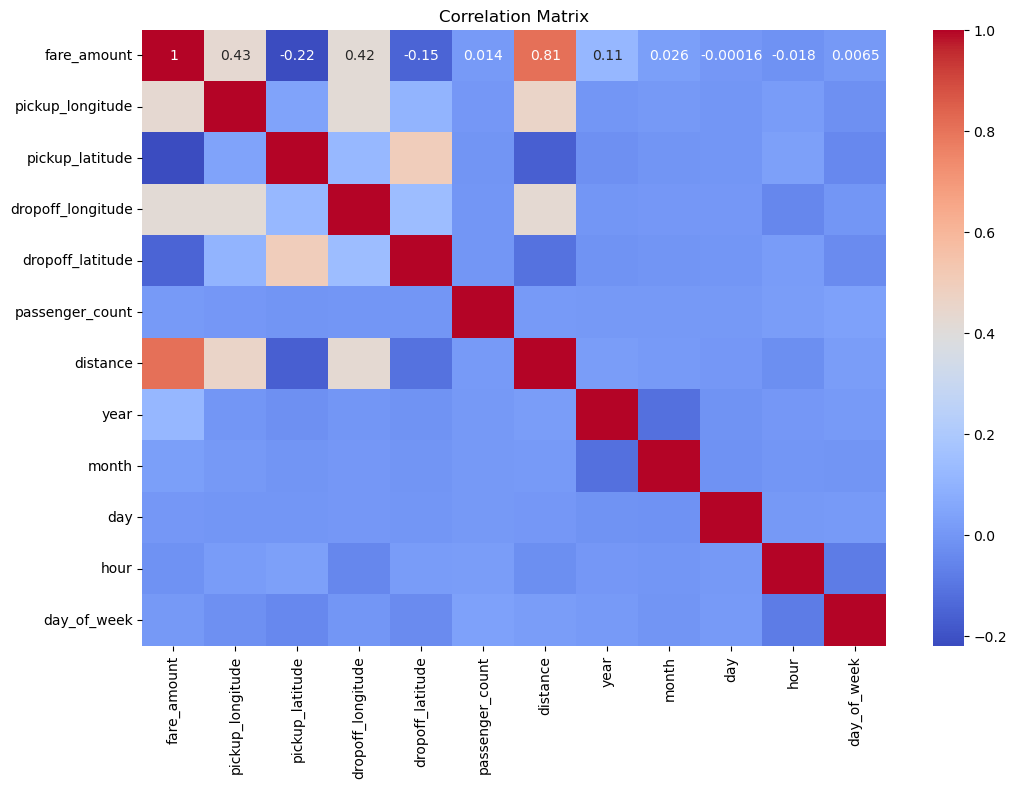

Lasso regularization
        Feature  Coefficient
5      distance     2.013642
6          year     0.490917
7         month     0.066718
9          hour     0.003669
10  day_of_week    -0.030181


In [21]:
# Correlation matrix
correlation_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Lasso regularization
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, Y_train)
lasso_coefficients = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': lasso.coef_})
print('Lasso regularization')
print(lasso_coefficients[lasso_coefficients['Coefficient'] != 0])

<Figure size 1000x600 with 0 Axes>

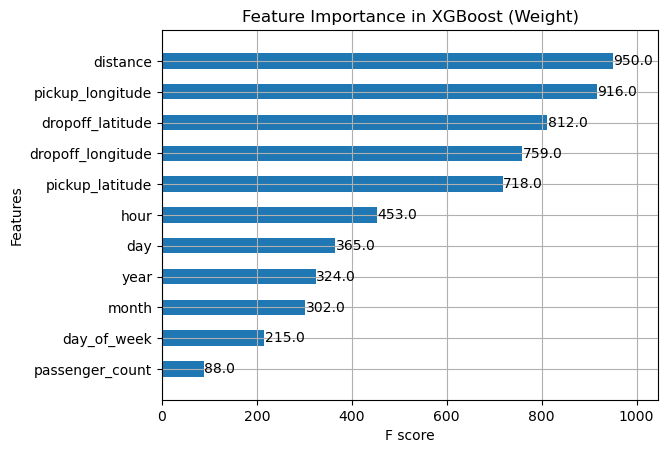

<Figure size 1000x600 with 0 Axes>

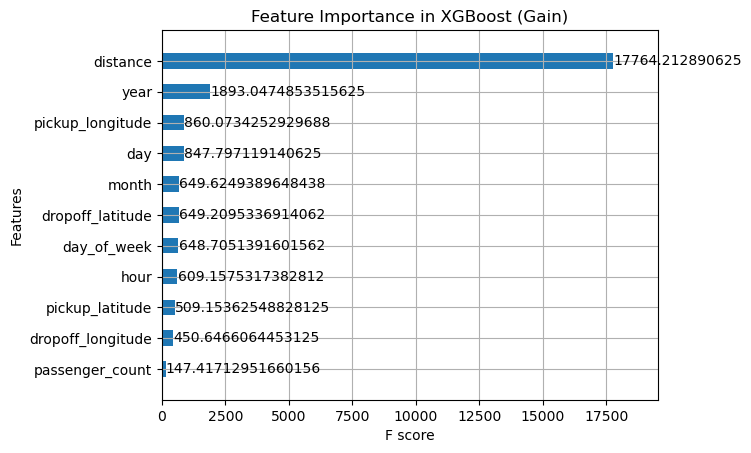

In [22]:
# Fit the XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, Y_train)

# Plot the feature importances for XGBoost model using 'weight'
plt.figure(figsize=(10, 6))
plot_importance(xgb_model, importance_type='weight', height=0.5)
plt.title('Feature Importance in XGBoost (Weight)')
plt.show()

# If you want to plot using 'gain' as well, you can do it similarly
plt.figure(figsize=(10, 6))
plot_importance(xgb_model, importance_type='gain', height=0.5)
plt.title('Feature Importance in XGBoost (Gain)')
plt.show()

In [23]:
# Define important features based on the analysis
important_features = ['distance', 'year', 'pickup_longitude', 'dropoff_latitude', 'pickup_latitude', 'dropoff_longitude', 'day', 'hour', 'month']

# Model with all features
lgb_model_all = lgb.LGBMRegressor(random_state=42, force_row_wise=True)
lgb_model_all.fit(X_train, Y_train)
Y_pred_all = lgb_model_all.predict(X_test)
rmse_all = np.sqrt(mean_squared_error(Y_test, Y_pred_all))
print(f"LightGBM with all features RMSE: {rmse_all}")

# Model with selected important features
X_train_imp = X_train[important_features]
X_test_imp = X_test[important_features]

lgb_model_imp = lgb.LGBMRegressor(random_state=42, force_row_wise=True)
lgb_model_imp.fit(X_train_imp, Y_train)
Y_pred_imp = lgb_model_imp.predict(X_test_imp)
rmse_imp = np.sqrt(mean_squared_error(Y_test, Y_pred_imp))
print(f"LightGBM with important features RMSE: {rmse_imp}")

# Compare the results
print(f"\nRMSE with all features: {rmse_all}")
print(f"RMSE with important features: {rmse_imp}")

[LightGBM] [Info] Total Bins 1366
[LightGBM] [Info] Number of data points in the train set: 120780, number of used features: 11
[LightGBM] [Info] Start training from score 11.033323
LightGBM with all features RMSE: 3.7659650862175313
[LightGBM] [Info] Total Bins 1352
[LightGBM] [Info] Number of data points in the train set: 120780, number of used features: 9
[LightGBM] [Info] Start training from score 11.033323
LightGBM with important features RMSE: 3.7520658929993775

RMSE with all features: 3.7659650862175313
RMSE with important features: 3.7520658929993775


# Prediction

In [24]:
# Retrain the best model on the full dataset and make final predictions
best_model = models[best_model_name]
best_model.fit(X_train_imp, Y_train)
Y_pred_best = best_model.predict(X_test_imp)

# Save the final predictions of the best model
final_predictions = pd.DataFrame({'actual_fare': Y_test, 'predicted_fare': Y_pred_best})
final_predictions['predicted_fare'] = final_predictions['predicted_fare'].round(1)

final_save_path = os.path.join('predictions.csv')
final_predictions.to_csv(final_save_path, index = False)
print(f"Final predictions saved to {final_save_path}")

# Load and display the saved final predictions CSV file to verify
final_predictions_loaded = pd.read_csv(final_save_path)
print(final_predictions_loaded.head(10))

[LightGBM] [Info] Total Bins 1352
[LightGBM] [Info] Number of data points in the train set: 120780, number of used features: 9
[LightGBM] [Info] Start training from score 11.033323
Final predictions saved to predictions.csv
   actual_fare  predicted_fare
0         10.5             9.9
1          5.0             4.9
2         12.5            10.7
3          3.7             5.0
4          8.5             6.4
5         10.1             9.6
6         20.0            18.0
7          4.9             5.0
8         16.0            18.5
9          7.5             7.3


# Optional: Hyperparameter Tuning

In [25]:
# Define the best parameters from Grid Search
best_params = {'learning_rate': 0.05, 'max_depth': 20, 'min_child_samples': 30, 'n_estimators': 300, 'num_leaves': 70}

# Initialize and train the final LightGBM model with the best parameters
final_model = lgb.LGBMRegressor(**best_params, random_state=42, force_row_wise=True)
final_model.fit(X_train, Y_train)

# Make predictions on the test data
Y_pred_test = final_model.predict(X_test)

# Calculate RMSE on the test data
test_rmse = np.sqrt(mean_squared_error(Y_test, Y_pred_test))
print(f"Test RMSE: {test_rmse}")

# Save the final predictions
final_predictions = pd.DataFrame({'actual_fare': Y_test, 'predicted_fare': Y_pred_test})
final_predictions['predicted_fare'] = final_predictions['predicted_fare'].round(1)

# Define the save path (local path)
final_save_path = os.path.join('final_fare_predictions.csv')
final_predictions.to_csv(final_save_path, index=False)
print(f"Final predictions saved to {final_save_path}\n")

# Load and display the saved final predictions CSV file to verify
final_predictions_loaded = pd.read_csv(final_save_path)
print(final_predictions_loaded.head(10))

[LightGBM] [Info] Total Bins 1366
[LightGBM] [Info] Number of data points in the train set: 120780, number of used features: 11
[LightGBM] [Info] Start training from score 11.033323
Test RMSE: 3.7173970237236516
Final predictions saved to final_fare_predictions.csv

   actual_fare  predicted_fare
0         10.5             9.9
1          5.0             4.8
2         12.5            11.3
3          3.7             5.4
4          8.5             6.1
5         10.1            10.1
6         20.0            18.5
7          4.9             5.2
8         16.0            18.8
9          7.5             7.1
